In [1]:
import os

from cartopy import crs as ccrs
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import optax
import xarray as xr

from jaxparrow import cyclogeostrophy, geostrophy
from jaxparrow.tools import geometry, kinematics, operators

%reload_ext autoreload
%autoreload 2

In [2]:
# utility functions

vmin = -4
vmax = -vmin
dpi_ref = 100
full_width_px = 1600


def get_figsize(width_ratio, wh_ratio=1):
    fig_width = full_width_px / dpi_ref * width_ratio
    fig_height = fig_width / wh_ratio
    return fig_width, fig_height

# Alboran sea

## Input data

In this example, we use NEMO model outputs (SSH and velocities), stored in several netCDF files.
Measurements are located on a C-grid.

Data can be downloaded [here](https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/fileServer/meomopendap/extract/MEOM/jaxparrow/alboransea.tar.gz), and the files extracted to the `data` folder.
The next cell does this for you, assuming wget and tar are available.

In [3]:
!wget -P data https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/fileServer/meomopendap/extract/MEOM/jaxparrow/alboransea.tar.gz
!tar -xzf data/alboransea.tar.gz -C data
!rm data/alboransea.tar.gz

--2024-03-27 10:49:31--  https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/fileServer/meomopendap/extract/MEOM/jaxparrow/alboransea.tar.gz
Resolving ige-meom-opendap.univ-grenoble-alpes.fr (ige-meom-opendap.univ-grenoble-alpes.fr)... 129.88.191.39
Connecting to ige-meom-opendap.univ-grenoble-alpes.fr (ige-meom-opendap.univ-grenoble-alpes.fr)|129.88.191.39|:443... connected.
HTTP request sent, awaiting response... 

/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


200 200
Length: 10021228 (9,6M) [application/octet-stream]
Saving to: ‘data/alboransea.tar.gz’

alboransea.tar.gz   100%[===================>]   9,56M  29,2MB/s    in 0,3s    

2024-03-27 10:49:31 (29,2 MB/s) - ‘data/alboransea.tar.gz’ saved [10021228/10021228]



In [4]:
data_dir = "data"
name_mask = "mask_alboransea.nc"
name_coord = "coordinates_alboransea.nc"
name_ssh = "alboransea_sossheig.nc"
name_u = "alboransea_sozocrtx.nc"
name_v = "alboransea_somecrty.nc"

In [5]:
ds_coord = xr.open_dataset(os.path.join(data_dir, name_coord))
lat_t = jnp.copy(ds_coord.nav_lat.values)
lon_t = jnp.copy(ds_coord.nav_lon.values)

ds_mask = xr.open_dataset(os.path.join(data_dir, name_mask))
mask = jnp.copy(ds_mask.tmask[0,0].values)

ds_ssh = xr.open_dataset(os.path.join(data_dir, name_ssh))
ssh = jnp.copy(ds_ssh.sossheig[0].values)

ds_u = xr.open_dataset(os.path.join(data_dir, name_u))
uvel = jnp.copy(ds_u.sozocrtx[0].values)

ds_v = xr.open_dataset(os.path.join(data_dir, name_v))
vvel = jnp.copy(ds_v.somecrty[0].values)

We use a mask `array` to restrict the domain to the marine area.

In [6]:
mask = 1 - mask

`jaxparrow` only needs the coordinates of the T points of the grid (`lat` and `lon` here).
The corresponding U and V coordinates are derived automatically using NEMO convention [see](https://www.nemo-ocean.eu/doc/node19.html), as in our example.

In [7]:
lat_u, lon_u, lat_v, lon_v = geometry.compute_uv_grids(lat_t, lon_t)

### Visualising SSH and currents

In [8]:
# compute some characteristics
norm_vorticity_t = kinematics.normalized_relative_vorticity(
    uvel, vvel, lat_u, lon_u, lat_v, lon_v, mask, interpolate=True
)
magnitude = ma.masked_array(kinematics.magnitude(uvel, vvel, interpolate=True), mask)

mmin = np.nanmin(magnitude)
mmax = np.nanmax(magnitude)

# interpolate to the center of the cells
uvel_t = operators.interpolation(uvel, axis=1, padding="left")
vvel_t = operators.interpolation(vvel, axis=0, padding="left")

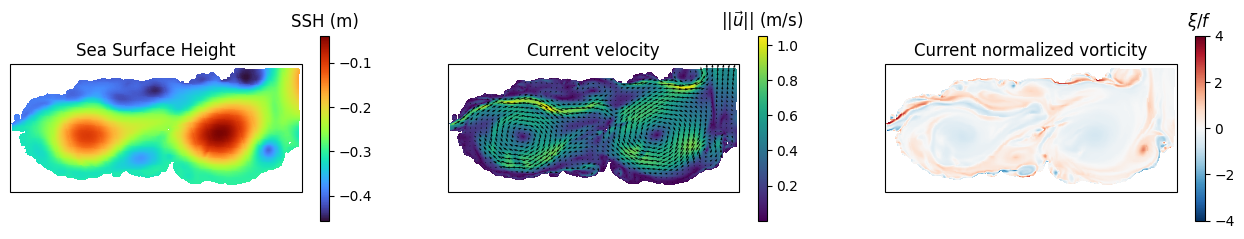

In [9]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=get_figsize(1, 20/3), 
                                  subplot_kw={"projection": ccrs.PlateCarree()})

ax1.set_title("Sea Surface Height")
im = ax1.pcolormesh(lon_t, lat_t, ma.masked_array(ssh, mask), 
                    cmap="turbo", shading="auto",
                    transform=ccrs.PlateCarree())
clb1 = plt.colorbar(im, ax=ax1)
clb1.ax.set_title("SSH (m)")

ax2.set_title("Current velocity")
im = ax2.pcolormesh(lon_t, lat_t, magnitude, 
                    shading="auto",
                    transform=ccrs.PlateCarree())
ax2.quiver(lon_t[::5, ::5], lat_t[::5, ::5], 
           ma.masked_array(uvel_t, mask)[::5, ::5], ma.masked_array(vvel_t, mask)[::5, ::5], 
           color="k")
clb2 = plt.colorbar(im, ax=ax2)
clb2.ax.set_title("$\\vert\\vert \\vec{u} \\vert\\vert$ (m/s)")

ax3.set_title("Current normalized vorticity")
im = ax3.pcolormesh(lon_t, lat_t, norm_vorticity_t, 
                    cmap="RdBu_r", shading="auto", 
                    vmin=vmin, vmax=vmax,
                    transform=ccrs.PlateCarree())
clb3 = plt.colorbar(im, ax=ax3)
clb3.ax.set_title("$\\xi / f$")

plt.show()

## Geostrophic balance

We estimate the geostrophic velocities using the `geostrophy` function, given the SSH, the coordinates of the T points, and an optional mask.
The function can also returns the the U and V coordinates of the velocity U and V components (they are the same as the one computed earlier for illustration, so we use `return_grids=False`).

In [10]:
u_geos, v_geos = geostrophy(ssh, lat_t, lon_t, mask, return_grids=False)

norm_vorticity_geos_t = kinematics.normalized_relative_vorticity(u_geos, v_geos, lat_u, lon_u, lat_v, lon_v, mask, interpolate=True)

### Comparison to NEMO's velocities

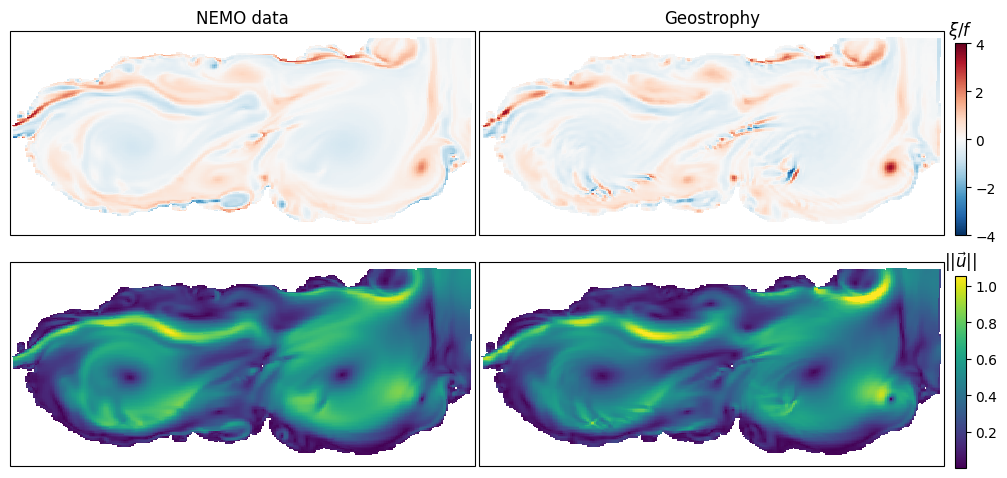

In [11]:
fig, axs = plt.subplots(2, 2, figsize=get_figsize(2/3, 12.66/6), 
                        subplot_kw={"projection": ccrs.PlateCarree()})

axs[0, 0].set_title("NEMO data")
_ = axs[0, 0].pcolormesh(lon_t, lat_t, norm_vorticity_t, 
                         cmap="RdBu_r", shading="auto", 
                         vmin=vmin, vmax=vmax,
                         transform=ccrs.PlateCarree())

axs[0, 1].set_title("Geostrophy")
im1 = axs[0, 1].pcolormesh(lon_t, lat_t, norm_vorticity_geos_t, 
                           cmap="RdBu_r", shading="auto", 
                           vmin=vmin, vmax=vmax,
                           transform=ccrs.PlateCarree())

_ = axs[1, 0].pcolormesh(lon_t, lat_t, magnitude, 
                         shading="auto", 
                         vmin=mmin, vmax=mmax,
                         transform=ccrs.PlateCarree())

im2 = axs[1, 1].pcolormesh(lon_t, lat_t, kinematics.magnitude(u_geos, v_geos, interpolate=True), 
                           shading="auto", 
                           vmin=mmin, vmax=mmax,
                           transform=ccrs.PlateCarree())

fig.tight_layout()
fig.subplots_adjust(right=0.89, wspace=0.01)

cbar_ax1 = fig.add_axes([0.9, 0.51, 0.01, 0.38])
_ = fig.colorbar(im1, cax=cbar_ax1)
cbar_ax1.set_title("$\\xi / f$")

cbar_ax2 = fig.add_axes([0.9, 0.05, 0.01, 0.38])
_ = fig.colorbar(im2, cax=cbar_ax2)
cbar_ax2.set_title("$\\vert\\vert \\vec{u} \\vert\\vert$")

plt.show()

## Cyclogeostrophic balance

### Variational method

Cyclogeostrophic velocities are computed via the `cyclogeostrophy` function, using geostrophic velocities (here, the ones we previously computed), spatial steps, and the coriolis factors.

The optimizer can be specified as a string (assuming it refers to an `optax` [common optimizers](https://optax.readthedocs.io/en/latest/api.html#)): `optim = "sgd"` for example.
Or designed using a more refined strategy:

In [12]:
lr_scheduler = optax.exponential_decay(1e-2, 200, .5)  # decrease the learning rate
optim = optax.sgd(learning_rate=lr_scheduler)  # basic SGD works nicely
optim = optax.chain(optax.clip(1), optim)  # prevent updates from exploding

As for the `geostrophy`, the `cyclogeostrophy` function can return the U and V points in addition to the velocity components. 
If specifying `return_geos=True`, the function also returns the geostrophic velocity.
Lastly, it is possible to get the evaluation of the cyclogeostrophic imbalance at each iteration by passing `return_losses=True`.

In [13]:
u_var, v_var, losses_var = cyclogeostrophy(ssh, lat_t, lon_t, mask, optim=optim, return_geos=False, return_grids=False, return_losses=True)

norm_vorticity_var_t = kinematics.normalized_relative_vorticity(u_var, v_var, lat_u, lon_u, lat_v, lon_v, mask, interpolate=True)

#### Comparison to NEMO's velocities

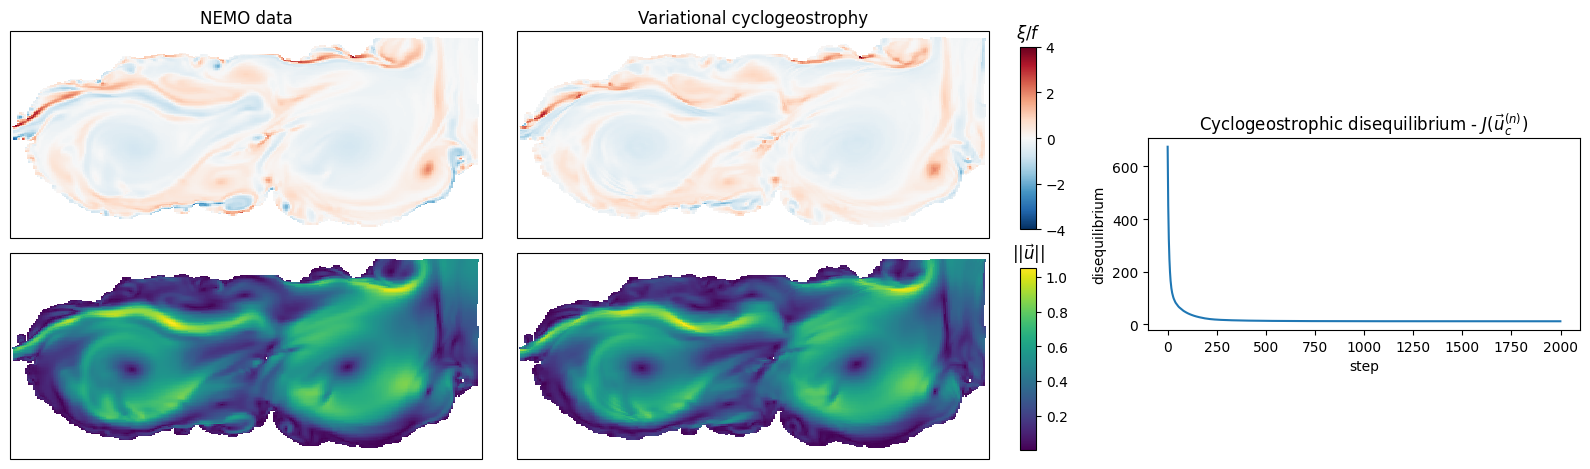

In [14]:
fig, axs = plt.subplots(2, 2, figsize=get_figsize(1, 20/6), 
                        subplot_kw={"projection": ccrs.PlateCarree()})

axs[0, 0].set_title("NEMO data")
_ = axs[0, 0].pcolormesh(lon_t, lat_t, norm_vorticity_t, cmap="RdBu_r", shading="auto", 
                         vmin=vmin, vmax=vmax,
                         transform=ccrs.PlateCarree())

axs[0, 1].set_title("Variational cyclogeostrophy")
im1 = axs[0, 1].pcolormesh(lon_t, lat_t, norm_vorticity_var_t, cmap="RdBu_r", shading="auto", 
                          vmin=vmin, vmax=vmax,
                          transform=ccrs.PlateCarree())

_ = axs[1, 0].pcolormesh(lon_t, lat_t, magnitude, 
                         shading="auto", 
                         vmin=mmin, vmax=mmax,
                         transform=ccrs.PlateCarree())

im2 = axs[1, 1].pcolormesh(lon_t, lat_t, kinematics.magnitude(u_var, v_var, interpolate=True), 
                           shading="auto", 
                           vmin=mmin, vmax=mmax,
                           transform=ccrs.PlateCarree())

fig.tight_layout()
fig.subplots_adjust(right=0.64, wspace=0.01)

cbar_ax1 = fig.add_axes([0.65, 0.51, 0.01, 0.38])
_ = fig.colorbar(im1, cax=cbar_ax1)
cbar_ax1.set_title("$\\xi / f$")

cbar_ax2 = fig.add_axes([0.65, 0.05, 0.01, 0.38])
_ = fig.colorbar(im2, cax=cbar_ax2)
cbar_ax2.set_title("$\\vert\\vert \\vec{u} \\vert\\vert$")
 
ax3 = fig.add_axes([0.73, 0.3, 0.27, 0.4])
ax3.set_title("Cyclogeostrophic disequilibrium - $J(\\vec{u}_c^{(n)})$")
ax3.set_xlabel("step")
ax3.set_ylabel("disequilibrium")
ax3.plot(losses_var)

plt.show()

### Iterative method

We use the same function, but with the argument `method="iterative"`. 

In [15]:
u_iterative, v_iterative, losses_it = cyclogeostrophy(ssh, lat_t, lon_t, mask, method="iterative", 
                                                      return_geos=False, return_grids=False, return_losses=True)

norm_vorticity_iterative_t = kinematics.normalized_relative_vorticity(u_iterative, v_iterative, lat_u, lon_u, lat_v, lon_v, mask, interpolate=True)

#### Comparison to NEMO's velocities

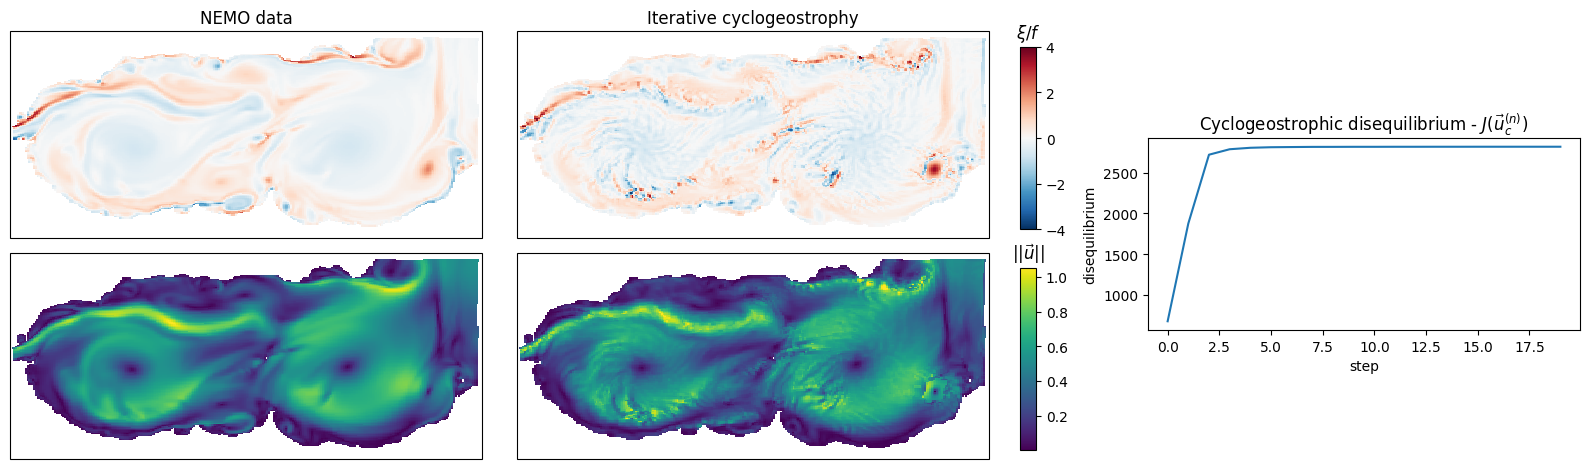

In [16]:
fig, axs = plt.subplots(2, 2, figsize=get_figsize(1, 20/6), 
                        subplot_kw={"projection": ccrs.PlateCarree()})

axs[0, 0].set_title("NEMO data")
_ = axs[0, 0].pcolormesh(lon_t, lat_t, norm_vorticity_t, cmap="RdBu_r", shading="auto", 
                         vmin=vmin, vmax=vmax,
                         transform=ccrs.PlateCarree())

axs[0, 1].set_title("Iterative cyclogeostrophy")
im1 = axs[0, 1].pcolormesh(lon_t, lat_t, norm_vorticity_iterative_t, cmap="RdBu_r", shading="auto", 
                           vmin=vmin, vmax=vmax,
                           transform=ccrs.PlateCarree())

_ = axs[1, 0].pcolormesh(lon_t, lat_t, magnitude, 
                         shading="auto", 
                         vmin=mmin, vmax=mmax,
                         transform=ccrs.PlateCarree())

im2 = axs[1, 1].pcolormesh(lon_t, lat_t, kinematics.magnitude(u_iterative, v_iterative, interpolate=True), 
                           shading="auto", 
                           vmin=mmin, vmax=mmax,
                           transform=ccrs.PlateCarree())

fig.tight_layout()
fig.subplots_adjust(right=0.64, wspace=0.01)

cbar_ax1 = fig.add_axes([0.65, 0.51, 0.01, 0.38])
_ = fig.colorbar(im1, cax=cbar_ax1)
cbar_ax1.set_title("$\\xi / f$")

cbar_ax2 = fig.add_axes([0.65, 0.05, 0.01, 0.38])
_ = fig.colorbar(im2, cax=cbar_ax2)
cbar_ax2.set_title("$\\vert\\vert \\vec{u} \\vert\\vert$")
 
ax3 = fig.add_axes([0.73, 0.3, 0.27, 0.4])
ax3.set_title("Cyclogeostrophic disequilibrium - $J(\\vec{u}_c^{(n)})$")
ax3.set_xlabel("step")
ax3.set_ylabel("disequilibrium")
ax3.plot(losses_it)

plt.show()

### Iterative method, with filter

We use the same function, but with the arguments `method="iterative"`, and `use_res_filter=True`. 

In [17]:
u_it_filter, v_it_filter, losses_it_filter = cyclogeostrophy(ssh, lat_t, lon_t, mask, method="iterative", use_res_filter=True, 
                                                             return_geos=False, return_grids=False, return_losses=True)

norm_vorticity_it_filter_t = kinematics.normalized_relative_vorticity(u_it_filter, v_it_filter, lat_u, lon_u, lat_v, lon_v, mask, interpolate=True)

#### Comparison to NEMO's currents

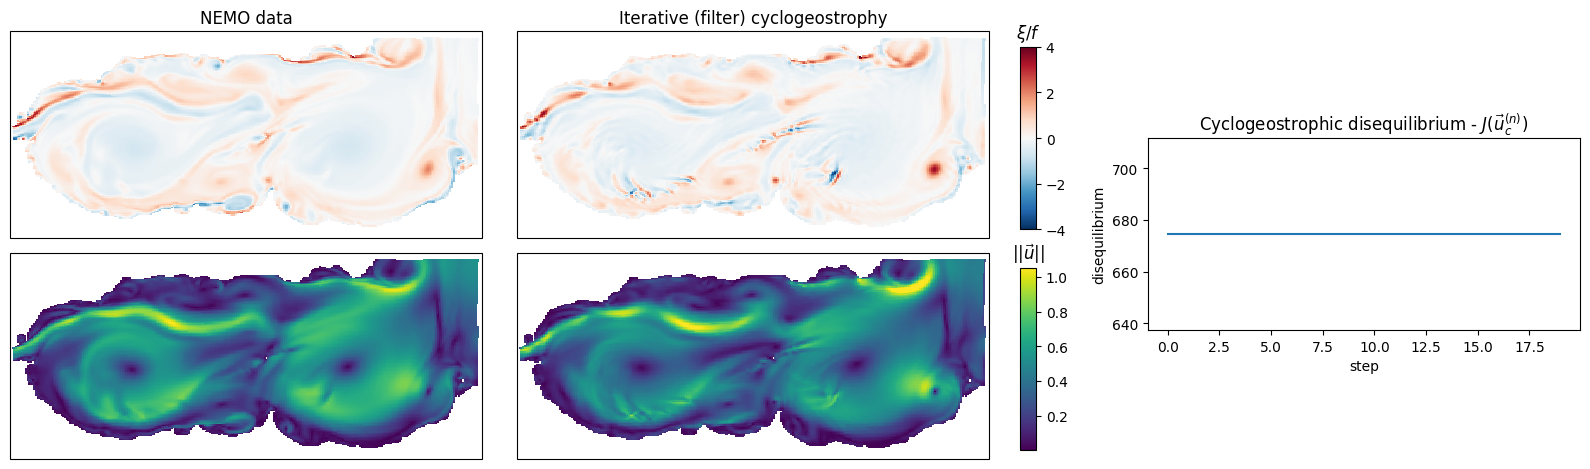

In [18]:
fig, axs = plt.subplots(2, 2, figsize=get_figsize(1, 20/6), 
                        subplot_kw={"projection": ccrs.PlateCarree()})

axs[0, 0].set_title("NEMO data")
_ = axs[0, 0].pcolormesh(lon_t, lat_t, norm_vorticity_t, cmap="RdBu_r", shading="auto", 
                         vmin=vmin, vmax=vmax,
                         transform=ccrs.PlateCarree())

axs[0, 1].set_title("Iterative (filter) cyclogeostrophy")
im1 = axs[0, 1].pcolormesh(lon_t, lat_t, norm_vorticity_it_filter_t, cmap="RdBu_r", shading="auto", 
                           vmin=vmin, vmax=vmax,
                           transform=ccrs.PlateCarree())

_ = axs[1, 0].pcolormesh(lon_t, lat_t, magnitude, 
                         shading="auto", 
                         vmin=mmin, vmax=mmax,
                         transform=ccrs.PlateCarree())

im2 = axs[1, 1].pcolormesh(lon_t, lat_t, kinematics.magnitude(u_it_filter, v_it_filter, interpolate=True), 
                           shading="auto", 
                           vmin=mmin, vmax=mmax,
                           transform=ccrs.PlateCarree())

fig.tight_layout()
fig.subplots_adjust(right=0.64, wspace=0.01)

cbar_ax1 = fig.add_axes([0.65, 0.51, 0.01, 0.38])
_ = fig.colorbar(im1, cax=cbar_ax1)
cbar_ax1.set_title("$\\xi / f$")

cbar_ax2 = fig.add_axes([0.65, 0.05, 0.01, 0.38])
_ = fig.colorbar(im2, cax=cbar_ax2)
cbar_ax2.set_title("$\\vert\\vert \\vec{u} \\vert\\vert$")
 
ax3 = fig.add_axes([0.73, 0.3, 0.27, 0.4])
ax3.set_title("Cyclogeostrophic disequilibrium - $J(\\vec{u}_c^{(n)})$")
ax3.set_xlabel("step")
ax3.set_ylabel("disequilibrium")
ax3.plot(losses_it_filter)

plt.show()

## Overall quantitative comparison

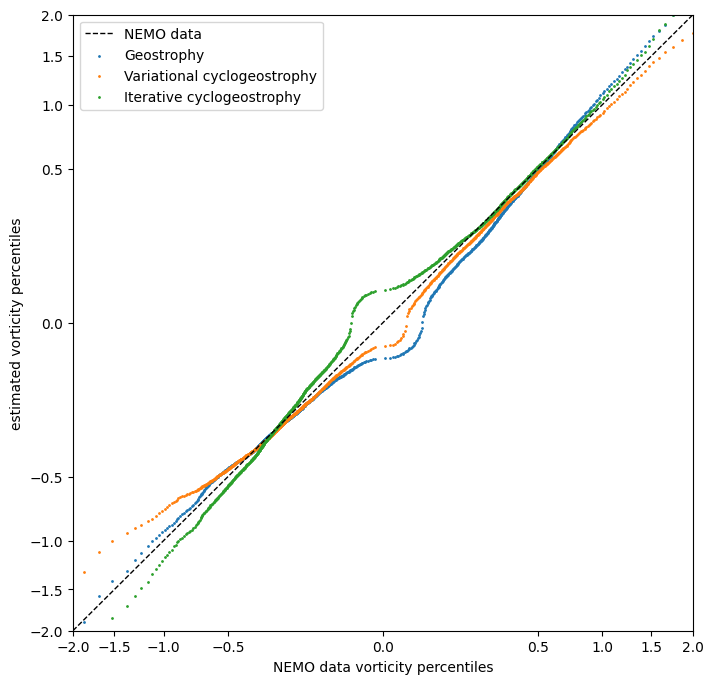

In [19]:
percentiles = np.linspace(0, 1, 1000)
vorticity_percentile = np.quantile(norm_vorticity_t[~np.isnan(norm_vorticity_t)], percentiles)
vorticity_percentile_geos = np.quantile(norm_vorticity_geos_t[~np.isnan(norm_vorticity_geos_t)], percentiles)
vorticity_percentile_var = np.quantile(norm_vorticity_var_t[~np.isnan(norm_vorticity_var_t)], percentiles)
vorticity_percentile_iterative = np.quantile(norm_vorticity_iterative_t[~np.isnan(norm_vorticity_iterative_t)], percentiles)

fig = plt.figure(figsize=get_figsize(.5))
ax = fig.add_subplot(1, 1, 1)
ax.axline(xy1=(vorticity_percentile.min(), vorticity_percentile.min()), 
          xy2=(vorticity_percentile.max(), vorticity_percentile.max()), 
          linestyle="dashed", linewidth=1, color="black", label="NEMO data")
ax.scatter(vorticity_percentile, vorticity_percentile_geos, 
           s=1, label="Geostrophy")
ax.scatter(vorticity_percentile, vorticity_percentile_var, 
           s=1, label="Variational cyclogeostrophy")
ax.scatter(vorticity_percentile, vorticity_percentile_iterative, 
           s=1, label="Iterative cyclogeostrophy")
ax.legend()
ax.set_xlabel("NEMO data vorticity percentiles")
ax.set_ylabel("estimated vorticity percentiles")
ax.set_xscale('function', functions=(lambda x: np.sign(x) * np.sqrt(np.abs(x)), 
                                     lambda x: np.sign(x) * x**2))
ax.set_yscale('function', functions=(lambda x: np.sign(x) * np.sqrt(np.abs(x)), 
                                     lambda x: np.sign(x) * x**2))
ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))

plt.show()